# Trabajo Práctico 1 AAII 2025 - Redes Densas y Convolucionales

**PROBLEMA 3 -GRUPO N° 5**

Autores:
- Herrera Morena (H-1187/8)
- Nardi Gianella Belén (N-1277/7)
- Zorzolo Rubio Juana (Z-1217/3)

# Problema 3



**Descripción**: En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

## Instalaciones e importaciones

In [1]:
!pip install -q gdown

In [59]:
import gdown
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path

from tensorflow.keras.layers import Input, RandomFlip, RandomContrast, RandomTranslation, Flatten, Dropout
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Add, ReLU, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization

# Corrected import: Only import PIL.Image once and correctly
from PIL import Image
from collections import Counter, defaultdict
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from IPython import get_ipython
# Remove the redundant import of Image from IPython.display
from IPython.display import display
import os
import tempfile

In [3]:
# Establecemos GPU por defecto si está disponible
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
# Fijar semilla
import random
semilla = 42
np.random.seed(semilla)
tf.random.set_seed(semilla)
random.seed(semilla)

In [5]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=f926e4d0-f777-4aee-a3c7-d7cbb951d3e6
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:05<00:00, 71.2MB/s]


'TP1-3-natural-scenes.zip'

In [6]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
  zip_ref.extractall('./TP1-3')

## Análisis y preprocesamiento de datos (EDA)

In [7]:
# Directorio de los datos
data_train = Path('/content/TP1-3/seg_train/seg_train')
data_test = Path('/content/TP1-3/seg_test/seg_test')

BATCH_SIZE = 32 # Tamaño del lote

# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Cargamos los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_train,
  label_mode="categorical",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_test,
  label_mode="categorical",
  image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  shuffle = False)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [8]:
# Inspeccionamos las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Total de imágenes analizadas (hasta 440 batches): 14034
Tamaños encontrados: {(150, 150, 3)}
Conteo por clase:
  - buildings: 2191 imágenes
  - forest: 2271 imágenes
  - glacier: 2404 imágenes
  - mountain: 2512 imágenes
  - sea: 2274 imágenes
  - street: 2382 imágenes


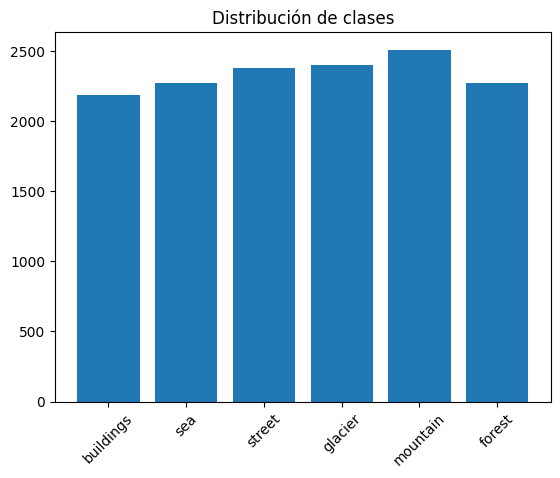

In [9]:
# Vemos la distribución de las clases del conjunto de datos TRAIN
def analizar_dataset_tf(train_ds, class_names=None, max_batches=440):
  conteo_clases = Counter()
  tamaños = set()
  total_imgs = 0

  for batch, (images, labels) in enumerate(train_ds.take(max_batches)):
    batch_size = images.shape[0]
    total_imgs += batch_size
    tamaños.update([tuple(images.shape[1:4])])

    for label in labels.numpy():
      idx = np.argmax(label)
      conteo_clases[idx] += 1

  print(f"Total de imágenes analizadas (hasta {max_batches} batches): {total_imgs}")
  print("Tamaños encontrados:", tamaños)

  print("Conteo por clase:")
  for idx, count in sorted(conteo_clases.items()):
    nombre = class_names[idx] if class_names else f"Clase {idx}"
    print(f"  - {nombre}: {count} imágenes")

  # Plot de clases
  if class_names:
    etiquetas = [class_names[idx] for idx in conteo_clases.keys()]
  else:
    etiquetas = list(conteo_clases.keys())

  plt.bar(etiquetas, conteo_clases.values())
  plt.xticks(rotation=45)
  plt.title("Distribución de clases")
  plt.show()

class_names = train_ds.class_names if hasattr(train_ds, 'class_names') else ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
analizar_dataset_tf(train_ds, class_names, max_batches=440)

Total de imágenes analizadas (hasta 440 batches): 3000
Tamaños encontrados: {(150, 150, 3)}
Conteo por clase:
  - buildings: 437 imágenes
  - forest: 474 imágenes
  - glacier: 553 imágenes
  - mountain: 525 imágenes
  - sea: 510 imágenes
  - street: 501 imágenes


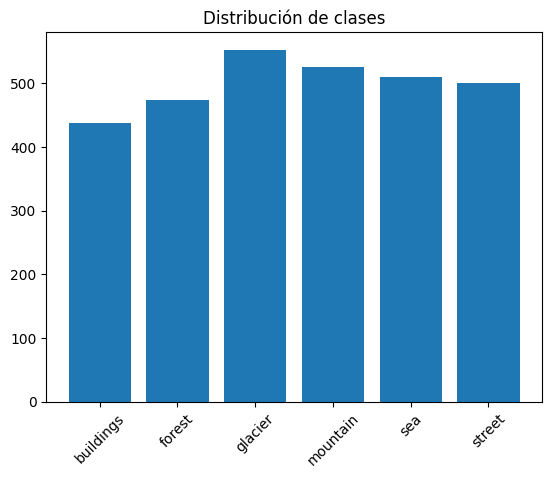

In [10]:
# Vemos la distribución de las clases del conjunto de datos TEST
analizar_dataset_tf(test_ds, class_names, max_batches=440)

Conclusión: Si bien las clases no tienen exactamente la misma cantidad de imágenes, la diferencia entre la que más tiene y la que menos tiene es relativamente baja (alrededor del 10-25%), por lo que concluimos que el conjunto de datos está relativamente balanceado.


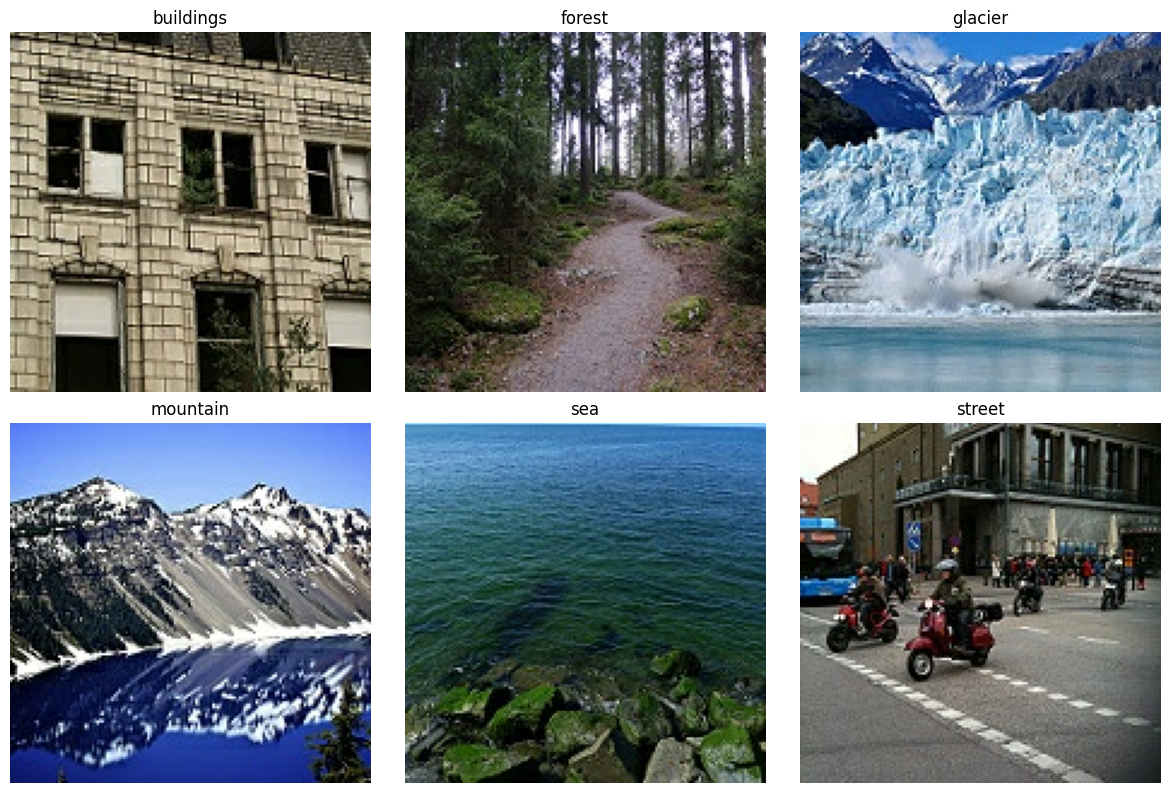

In [11]:
# Mostramos imágenes por clase
def mostrar_ejemplos_por_clase(dataset, class_names):
  fig, axes = plt.subplots(2, 3, figsize=(12, 8))
  mostradas = [False] * len(class_names)

  for images, labels in dataset.unbatch().take(1000):
    idx = np.argmax(labels.numpy())
    if not mostradas[idx]:
      ax = axes[idx // 3, idx % 3]
      ax.imshow(images.numpy().astype("uint8"))
      ax.set_title(class_names[idx])
      ax.axis("off")
      mostradas[idx] = True
    if all(mostradas):
      break

  plt.tight_layout()
  plt.show()

# Del conjunto de datos TRAIN
mostrar_ejemplos_por_clase(train_ds, class_names)

In [12]:
# Vemos valores de píxeles
for images, _ in train_ds.take(1):
  print("Mínimo valor de pixel:", images.numpy().min())
  print("Máximo valor de pixel:", images.numpy().max())

Mínimo valor de pixel: 0.0
Máximo valor de pixel: 255.0


Conclusión del Análisis y Preprocesamiento de los datos (EDA):

Este análisis nos indica que las imágenes son todas de un mismo tamaño y tienen un rango de valores adecuado. Además, las distribuciones por clase se encuentran relativamente balanceadas tanto en train como en test.
Los ejemplos de imágenes que visualizamos etiquetados con sus respectivas clases son coherentes con cada categoría.

## Definición y entrenamiento de modelos

Descomentar en caso de que se quiera reducir el tamaño del dataset para simular otro escenario o el tiempo de ejecución.


In [13]:
# train_ds = train_ds.take(7500)
# test_ds = test_ds.take(1500)

A continuación se definen funciones de utilidad en todos los modelos.

In [14]:
def plot_confusion_matrix(model, test_ds):
  class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
  y_pred = np.argmax(model.predict(test_ds), axis=1)

  y_true = np.concatenate([y for x, y in test_ds])
  y_true = np.argmax(y_true, axis=1)

  # Matriz de Confusión
  cm = confusion_matrix(y_true, y_pred)

  # Mostrar la matriz visual
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap='Blues', xticks_rotation=45)
  plt.title("Matriz de Confusión")
  plt.show()

  # Mostrar con nombres de clases
  cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
  print("\nMatriz de Confusión con Nombres de Clases:")
  print(cm_df)

In [15]:
def plot_training(historia, nombre_modelo):
  acc = historia.history['accuracy']
  val_acc = historia.history['val_accuracy']
  loss = historia.history['loss']
  val_loss = historia.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, acc, 'bo-', label='Train accuracy')
  plt.plot(epochs, val_acc, 'ro-', label='Val accuracy')
  plt.title(f'Accuracy - {nombre_modelo}')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, loss, 'bo-', label='Train loss')
  plt.plot(epochs, val_loss, 'ro-', label='Val loss')
  plt.title(f'Loss - {nombre_modelo}')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [53]:
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

In [17]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
ruta_imagenes = Path("/content/TP1-3/seg_train/seg_train")

### Modelo con capas densas

In [18]:
# Modelo simple de capas densas
def crear_modelo_denso(input_shape, num_classes):
  modelo = Sequential([
    Input(shape=input_shape),
    Rescaling(1./255),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
  ])
  return modelo

# Creamos el modelo
modelo_denso = crear_modelo_denso((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
optimizer = Adam(learning_rate=0.0005)
modelo_denso.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Entrenamiento del modelo
historial_denso = modelo_denso.fit(train_ds, validation_data=test_ds, epochs=40, callbacks=callbacks)

Epoch 1/40
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.2946 - loss: 4.0287 - val_accuracy: 0.4477 - val_loss: 1.4051 - learning_rate: 5.0000e-04
Epoch 2/40
439/439 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3985 - loss: 1.4745 - val_accuracy: 0.4827 - val_loss: 1.3451 - learning_rate: 5.0000e-04
Epoch 3/40
439/439 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.4214 - loss: 1.4328 - val_accuracy: 0.3897 - val_loss: 1.4652 - learning_rate: 5.0000e-04
Epoch 4/40
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.4129 - loss: 1.4433 - val_accuracy: 0.4810 - val_loss: 1.3512 - learning_rate: 5.0000e-04
Epoch 5/40
437/439 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4360 - loss: 1.4059
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
439/439 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.4360 - loss: 1.4059 - val_accuracy: 0.4810 - val_loss: 1.3762 - learning_rate: 5.0000e-04
Epoch 6/40
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accur

#### Modelo

In [19]:
modelo_denso.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    34,560,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,176,532 (397.40 MB)

 Trainable params: 34,725,510 (132.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 69,451,022 (264.93 MB)

#### Evaluación

In [20]:
# Evaluamos el modelo en el conjunto de datos TEST
loss, accuracy = modelo_denso.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5603 - loss: 1.1873
Pérdida en test: 1.1752
Precisión en test: 0.5627


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


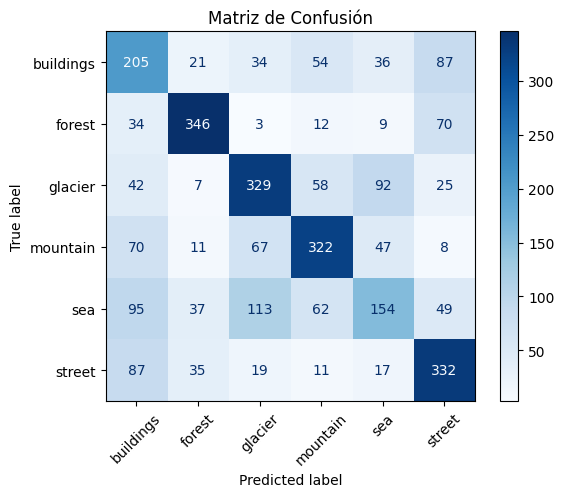


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings        205      21       34        54   36      87
forest            34     346        3        12    9      70
glacier           42       7      329        58   92      25
mountain          70      11       67       322   47       8
sea               95      37      113        62  154      49
street            87      35       19        11   17     332


In [21]:
# Matriz de confusión
plot_confusion_matrix(modelo_denso, test_ds)

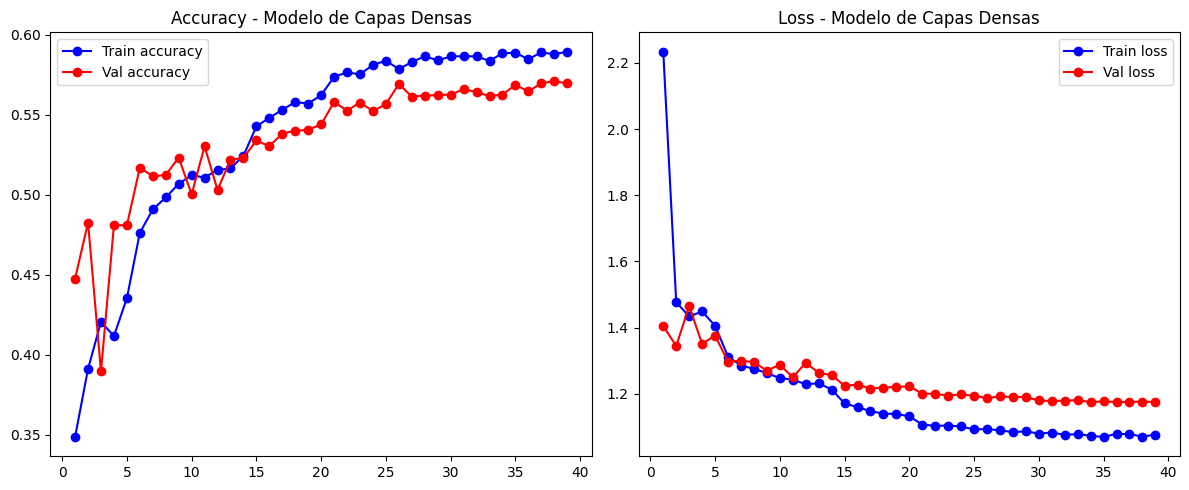

In [22]:
# Graficamos la evolución del entrenamiento
plot_training(historial_denso, "Modelo de Capas Densas")

Probamos el modelo en una imagen de cada clase y lo mostramos:

In [23]:
class_names = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [24]:
ruta_imagenes = Path("/content/TP1-3/seg_train/seg_train")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


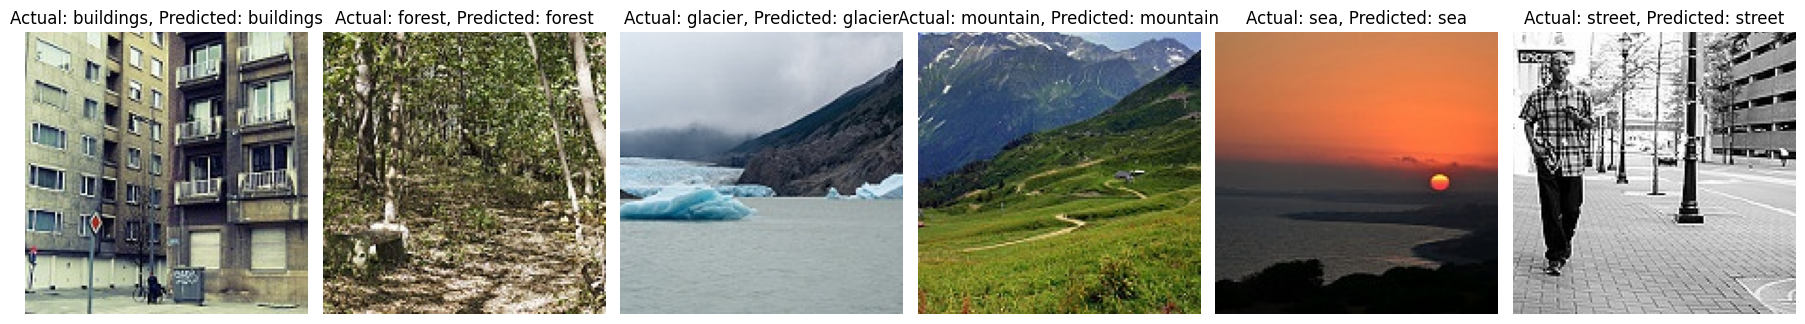

In [32]:
# Seleccionamos una imagen aleatoria de cada clase
sample_images = []
for class_name in class_names:
    class_folder = data_train / class_name
    image_paths = list(class_folder.glob("*.jpg"))
    selected_image = random.choice(image_paths)
    sample_images.append((selected_image, class_name))

# Mostrar 6 imágenes con sus clases reales y predichas
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for i, ax in enumerate(axes):

    # Preprocesar imagen
    image_path, actual_class = sample_images[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    # Agregar dimensión batch
    image = np.expand_dims(image, axis=0)

    # Predecir
    prediction = modelo_denso.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### Conclusión

In [33]:
# Creamos un data para comparar el rendimiento de los modelos
comparacion = pd.DataFrame({
  'Modelo': ['Modelo Denso'],
  'Precisión en test': [accuracy],
  'Pérdida en test': [loss]
})

In [34]:
comparacion

Modelo  Precisión en test  Pérdida en test
0  Modelo Denso           0.562667         1.175239

El modelo de capas densas tiene un rendimiento moderado, con un 53% de acierto en las predicciones y una pérdida de 1.2, indicandonos que presenta algunas dificultades para ajustarse a los datos. Este desempeño nos muestra que las redes densas no son adecuadas para tareas de clasificación de imágenes, ya que tratan cada imagen como una secuencia plana de píxeles sin considerar su estructura espacial, limitando así la extracción de patrones visuales relevantes.

Según los resultados de la matriz de confusión 'sea' y 'buildings' son las que tienen más dificultades para ser clasificadas.

Según las curvas de entrenamiento tanto loss como accuracy convergen en train y en test.

Como conclusión, los resultados obtenidos significan que, si bien el modelo logra generalizar, no es el más adecuado para este tipo de tareas.

### Modelo con capas convolucionales y densas

In [35]:
# Modelo con capas convolucionales y densas
def crear_modelo_conv_denso(input_shape, output_labels):
  i = Input(input_shape, dtype=tf.float32)

  # Estas capas aumentan la variedad del conjunto de datos "en vivo" durante el entrenamiento
  x = Rescaling(1./255)(i) # Normaliza la imagen a [0, 1]
  x = RandomFlip("horizontal")(x) # Giro horizontal
  x = RandomFlip("vertical")(x) # Giro vertical
  x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x) # Traslación
  x = RandomContrast(0.2)(x)  # Cambio de contraste

  x = Conv2D(8, (3, 3))(x) # Filtros conv con kernel 3x3
  x = BatchNormalization()(x) # Reduce el riesgo de overfitting
  x = Activation("relu")(x)

  x = Conv2D(16, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x) # Activa las salidas de cada convolución

  x = MaxPooling2D((2, 2))(x) # Reduce la resolución espacial, conservando las características más importantes

  x = Conv2D(32, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = MaxPooling2D((2, 2))(x)

  x = Conv2D(64, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.5)(x) # Aumentamos a 0.5
  x = Dense(output_labels)(x)
  x = Activation("softmax")(x)
  return tf.keras.Model(inputs=[i], outputs=[x])

# Creamos el modelo
modelo_conv_denso = crear_modelo_conv_denso((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
modelo_conv_denso.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks para evitar overfitting
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Entrenamos el modelo
historia_conv_denso = modelo_conv_denso.fit(train_ds, validation_data=test_ds, epochs=20, batch_size=BATCH_SIZE, callbacks=callbacks)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


439/439 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.4262 - loss: 2.5718 - val_accuracy: 0.4587 - val_loss: 1.9365 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6059 - loss: 1.1534 - val_accuracy: 0.6667 - val_loss: 0.9011 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6747 - loss: 0.8921 - val_accuracy: 0.7237 - val_loss: 0.7469 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.6999 - loss: 0.8080 - val_accuracy: 0.7030 - val_loss: 0.8555 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.7239 - loss: 0.7297 - val_accuracy: 0.6887 - val_loss: 0.8039 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.7417 - loss: 0.6902 - val_accuracy: 0.7480 - val_loss: 0.7197 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.7611 - loss: 0.6634

#### Modelo

In [36]:
modelo_conv_denso.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation              │ (None, 150, 150, 3)    │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 150, 150, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 16)   │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 35, 35, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             

 Total params: 369,476 (1.41 MB)

 Trainable params: 123,078 (480.77 KB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 246,158 (961.56 KB)

#### Evaluación

In [37]:
# Evaluamos el modelo con el conjunto de datos TEST
loss, accuracy = modelo_conv_denso.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8352 - loss: 0.4425
Pérdida en test: 0.4529
Precisión en test: 0.8357


 1/94 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(32, 150, 150, 3))
  warnings.warn(msg)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


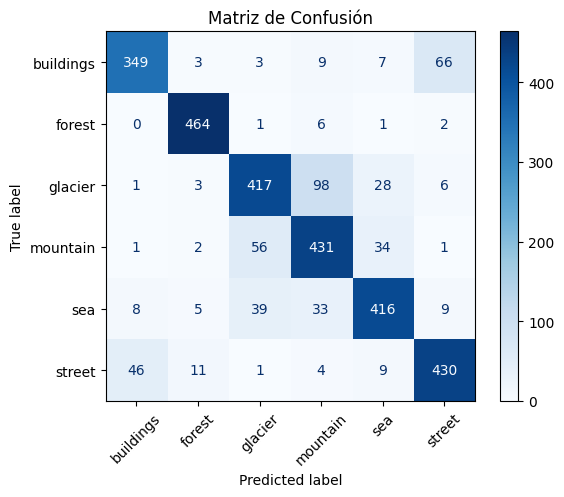


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings        349       3        3         9    7      66
forest             0     464        1         6    1       2
glacier            1       3      417        98   28       6
mountain           1       2       56       431   34       1
sea                8       5       39        33  416       9
street            46      11        1         4    9     430


In [38]:
# Matriz de confusión
plot_confusion_matrix(modelo_conv_denso, test_ds)

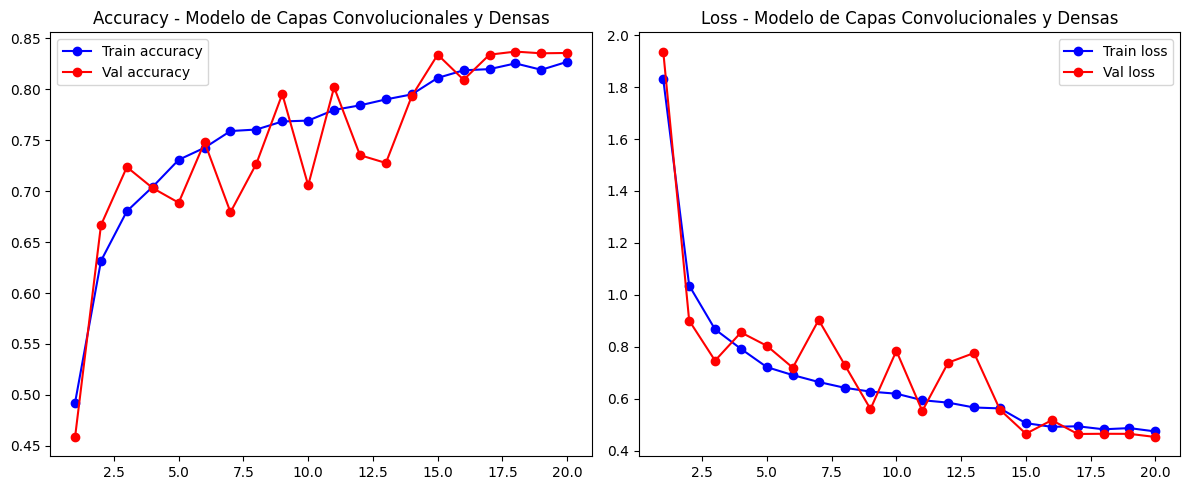

In [39]:
plot_training(historia_conv_denso, "Modelo de Capas Convolucionales y Densas")

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_8']
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


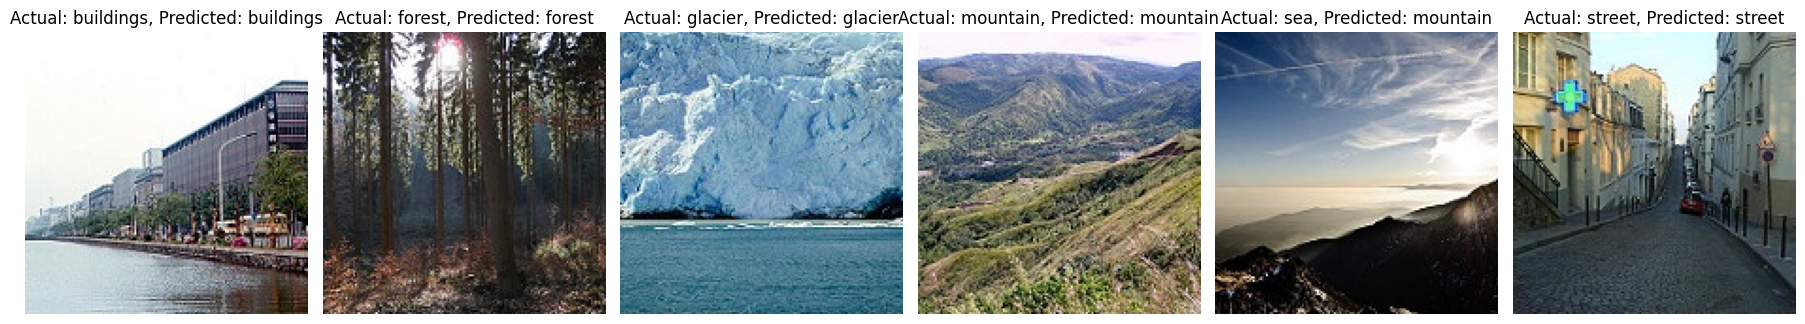

In [40]:
# Seleccionamos una imagen aleatoria de cada clase
sample_images = []
for class_name in class_names:
    class_folder = data_train / class_name
    image_paths = list(class_folder.glob("*.jpg"))
    selected_image = random.choice(image_paths)
    sample_images.append((selected_image, class_name))

# Mostrar 6 imágenes con sus clases reales y predichas
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for i, ax in enumerate(axes):

    # Preprocesar imagen
    image_path, actual_class = sample_images[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    # Agregar dimensión batch
    image = np.expand_dims(image, axis=0)

    # Predecir
    prediction = modelo_conv_denso.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### Conclusión

In [41]:
metricas_modelo_denso = {
    'Modelo': 'Modelo Convolucional y Denso',
    'Precisión en test': accuracy,
    'Pérdida en test': loss
}
comparacion.loc[len(comparacion)] = metricas_modelo_denso
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.562667         1.175239
1  Modelo Convolucional y Denso           0.835667         0.452867

El modelo de capas convolucionales y densas tiene un buen rendimiento, con un 80% de acierto en las predicciones y una pérdida de 0.54, indicandonos que generaliza correctamente. Este desempeño nos muestra que el uso de capas convolucionales permitió extraer características espaciales relevantes, mejorando significativamente el desempeño respecto al modelo de capas densas.

Según los resultados de la matriz de confusión, el modelo generaliza mucho mejor, aunque continúa confundiendo glaciar con montaña.

Según las curvas de entrenamiento en el conjunto de validación no converge de forma estable, lo que nos muestra que el modelo está overfiteando.

En resumen, el modelo dio mejores resultados que el de capas densas. Además, el uso de técnicas de aumento de datos (data augmentation) contribuyó a mitigar el sobreajuste.

### Modelo que incluya bloques residuales identidad

In [42]:
# Definimos el bloque residual
def resnet_block(x, filters, downsample=False):
  shortcut = x
  strides = (2, 2) if downsample else (1, 1)

  x = Conv2D(filters, (3, 3), strides=strides, padding='same', kernel_initializer='he_normal')(x)
  x = ReLU()(x)
  x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)

  if downsample:
    shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same', kernel_initializer='he_normal')(shortcut)

  x = Add()([x, shortcut])
  x = ReLU()(x)
  return x

In [43]:
# Modelo con uso de boques residuales
def build_resnet_like_model(input_shape=(150, 150, 3), num_classes=6):
  inputs = Input(shape=input_shape)
  x = tf.keras.layers.Rescaling(1./255)(inputs)

  x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', kernel_initializer='he_normal')(x)
  x = ReLU()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

  x = resnet_block(x, 64)
  x = resnet_block(x, 64)

  x = resnet_block(x, 128, downsample=True)
  x = resnet_block(x, 128)

  x = GlobalAveragePooling2D()(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(num_classes, activation='softmax')(x)
  return Model(inputs, outputs)

# Compilamos
model_resnet_like = build_resnet_like_model(input_shape=(150, 150, 3), num_classes=num_classes)
model_resnet_like.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks para evitar overfitting.
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

# Entrenamos el modelo
history_resnet_like = model_resnet_like.fit(train_ds, validation_data=test_ds, epochs=20, callbacks=callbacks)

Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3528 - loss: 1.5939 - val_accuracy: 0.5733 - val_loss: 1.0950 - learning_rate: 1.0000e-04
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 31s 32ms/step - accuracy: 0.5941 - loss: 1.0378 - val_accuracy: 0.6773 - val_loss: 0.8466 - learning_rate: 1.0000e-04
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6752 - loss: 0.8622 - val_accuracy: 0.7453 - val_loss: 0.6995 - learning_rate: 1.0000e-04
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7238 - loss: 0.7490 - val_accuracy: 0.7823 - val_loss: 0.6413 - learning_rate: 1.0000e-04
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.7590 - loss: 0.6753 - val_accuracy: 0.7657 - val_loss: 0.6584 - learning_rate: 1.0000e-04
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.7750 - loss: 0.6253 - val_accuracy: 0.7933 - val_loss: 0.5845 - learning_rate: 1.0000e-04
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/ste

#### Modelo

In [44]:
model_resnet_like.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 150, 150,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 75, 75,    │      9,472 │ rescaling_2[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 75, 75,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 38, 38,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 38, 38,    │     36,928 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 38, 38,    │          0 │ conv2d_5[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 38, 38,    │          0 │ conv2d_6[0][0],   │
│                     │ 64)               │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 38, 38,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 38, 38,    │          0 │ conv2d_7[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 38, 38,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 38, 38,    │          0 │ conv2d_8[0][0],   │
│                     │ 64)               │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 38, 38,    │          0 │ add_1[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 19, 19,    │     73,856 │ re_lu_4[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 19, 19,    │          0 │ conv2d_9[0][0]  

 Total params: 2,098,196 (8.00 MB)

 Trainable params: 699,398 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,398,798 (5.34 MB)

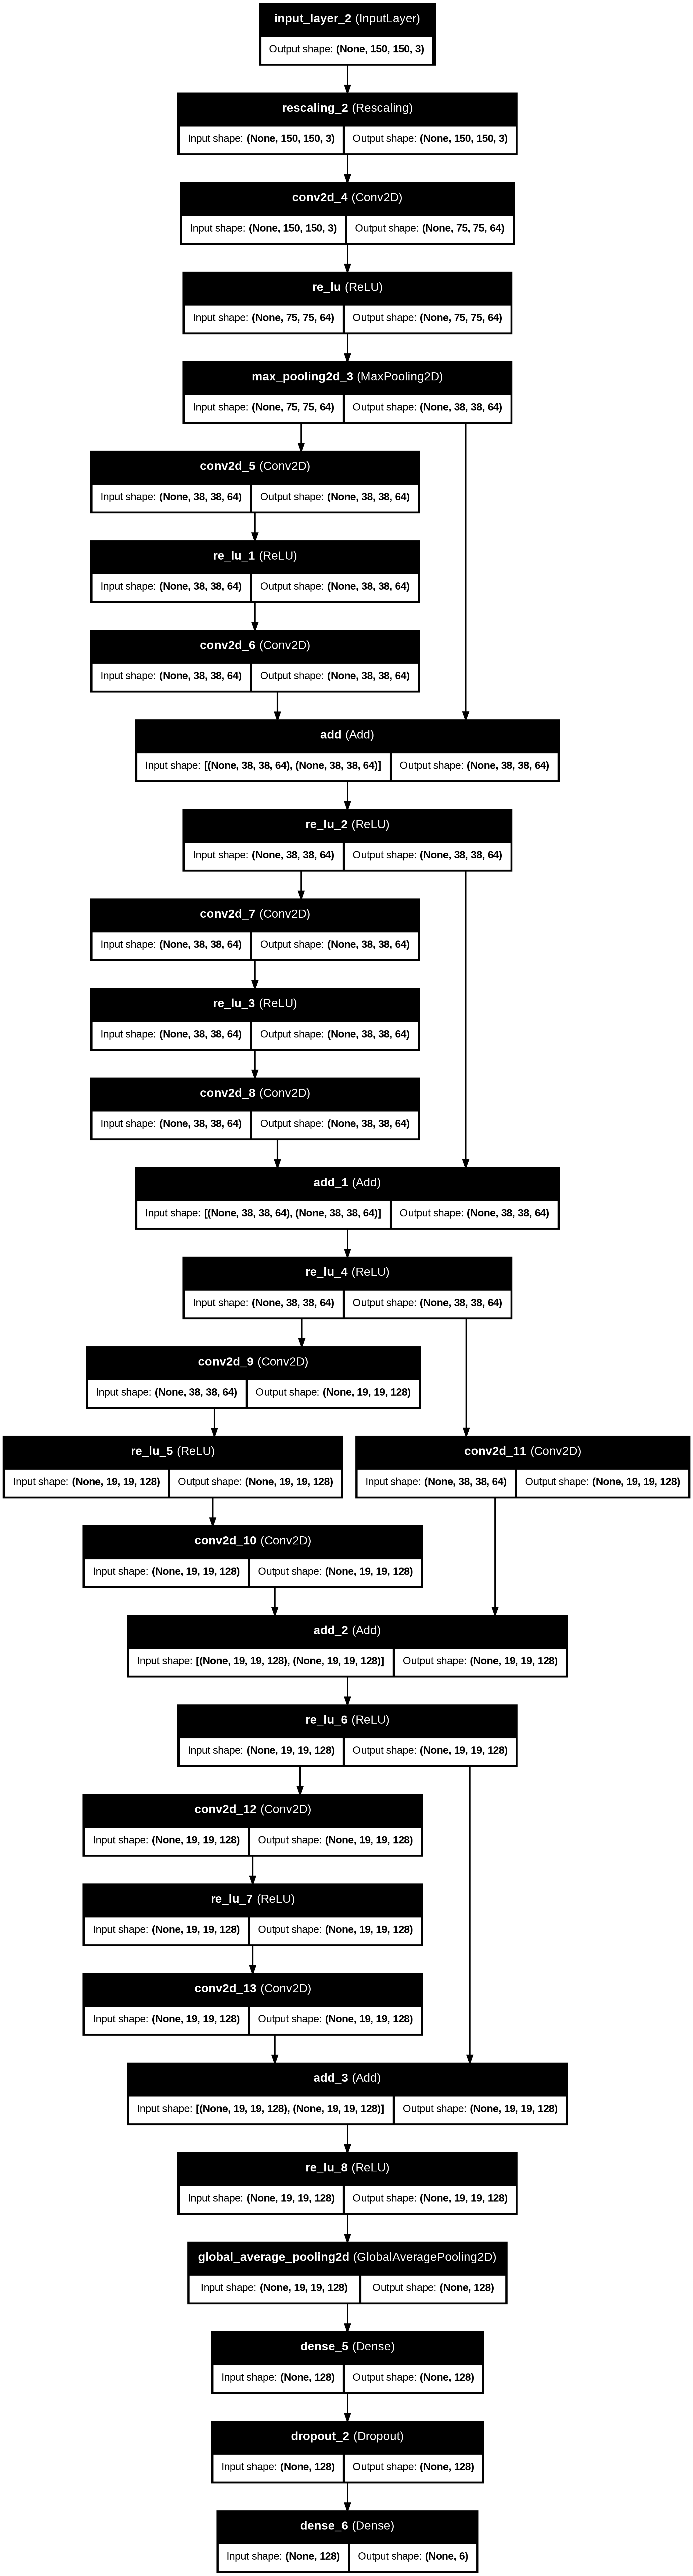

In [54]:
# Creamos la imagen temporal del modelo
with tempfile.NamedTemporaryFile(suffix=".png") as tmpfile:
  plot_model(model_resnet_like, to_file=tmpfile.name, show_shapes=True, show_layer_names=True)
  display(Image(filename=tmpfile.name))

#### Evaluación

In [55]:
# Evaluamos el modelo en el conjunto de datos TEST
test_loss, test_acc = model_resnet_like.evaluate(test_ds)
print(f"Accuracy en test: {test_acc:.4f}")
print(f"Pérdida en test: {test_loss:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8909 - loss: 0.3159
Accuracy en test: 0.8810
Pérdida en test: 0.3496


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


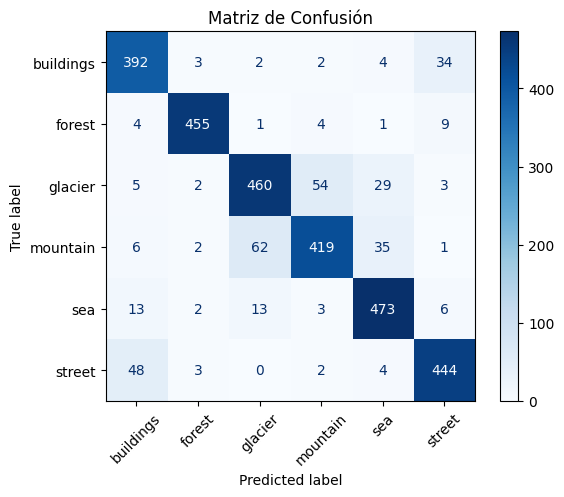


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings        392       3        2         2    4      34
forest             4     455        1         4    1       9
glacier            5       2      460        54   29       3
mountain           6       2       62       419   35       1
sea               13       2       13         3  473       6
street            48       3        0         2    4     444


In [56]:
# Matriz de confusión
plot_confusion_matrix(model_resnet_like, test_ds)

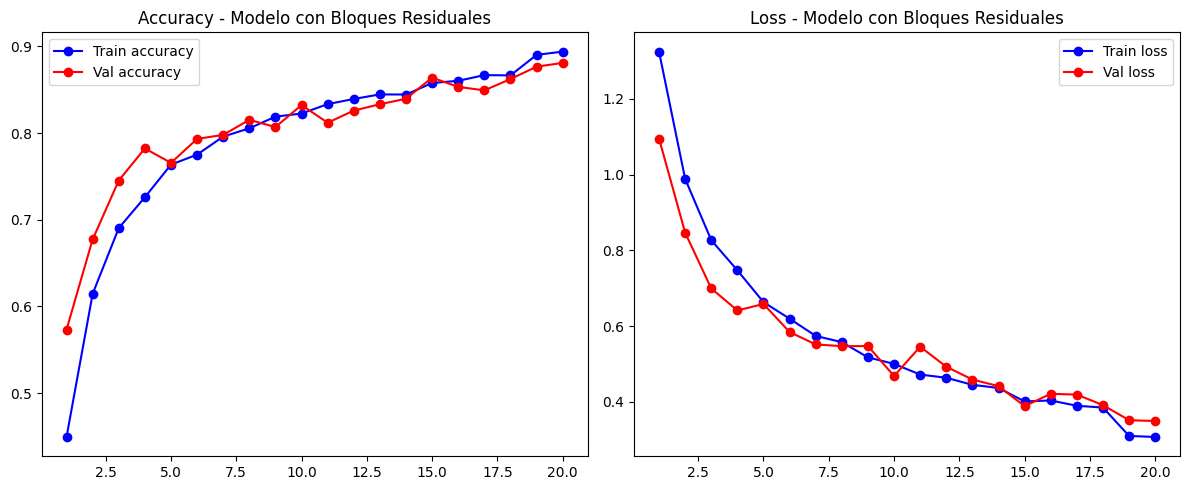

In [57]:
# Graficamos la evolución del entrenamiento
plot_training(history_resnet_like, "Modelo con Bloques Residuales")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


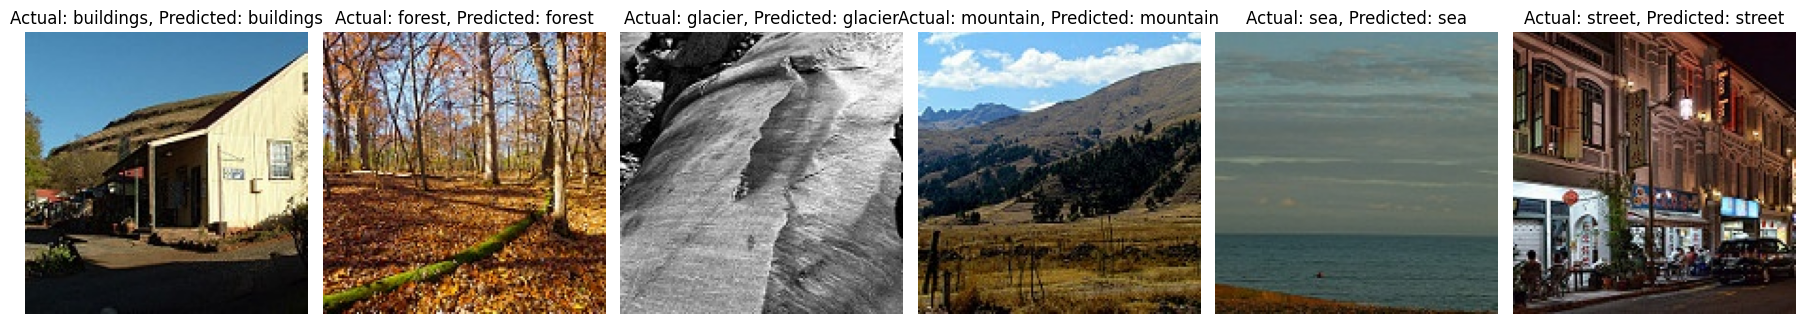

In [60]:
# Seleccionamos una imagen aleatoria de cada clase
sample_images = []
for class_name in class_names:
    class_folder = data_train / class_name
    image_paths = list(class_folder.glob("*.jpg"))
    selected_image = random.choice(image_paths)
    sample_images.append((selected_image, class_name))

# Mostrar 6 imágenes con sus clases reales y predichas
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for i, ax in enumerate(axes):

    # Preprocesar imagen
    image_path, actual_class = sample_images[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    # Agregar dimensión batch
    image = np.expand_dims(image, axis=0)

    # Predecir
    prediction = model_resnet_like.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### Conclusión

In [61]:
metricas_bloques_residuales = {
    'Modelo': 'Modelo Bloques Residuales',
    'Precisión en test': test_acc,
    'Pérdida en test': test_loss
}
comparacion.loc[len(comparacion)] = metricas_bloques_residuales
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.562667         1.175239
1  Modelo Convolucional y Denso           0.835667         0.452867
2     Modelo Bloques Residuales           0.881000         0.349607

El modelo de bloques residuales tiene un buen rendimiento, con un 87% de acierto en las predicciones y una pérdida de 0.35, indicandonos que generaliza correctamente. La arquitectura nos permitió mejorar el desempeño mediante conexiones de atajo, manteniendo la estabilidad del entrenamiento.

Según los resultados de la matriz de confusión se clasifican correctamente todas las clases, requiriendo una mejora para la identificación de 'mountain', la cual es confundida con 'glacier'.

Según las curvas de entrenamiento:
- Accuracy: la precisión de entrenamiento y validación convergen de forma estable y cercana.
- Loss: la pérdida disminuye progresivamente en entrenamiento y validación.
El modelo se ajusta bien a los datos, con un leve sobreajuste.

Como conclusión, el modelo tuvo un buen rendimiento general.

### Modelo que utilice como backbone alguna arquitectura disponibles en TensorFlow (transfer learning)

EfficientNetB0



In [62]:
# Modelo con el uso de TensorFlow (EfficientNetB0)
def build_tensorflow_model(input_shape, num_classes):
  base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')
  base_model.trainable = False

  i = Input(shape=input_shape)
  x = base_model(i, training=False)
  x = GlobalAveragePooling2D()(x)

  x = Dropout(0.5)(x)
  x = Dense(num_classes, activation='softmax')(x)
  return tf.keras.Model(i, x)

# Creamos el modelo
model_tensorflow = build_tensorflow_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

# Compilamos el modelo
model_tensorflow.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

# Callbacks para evitar overfitting
callbacks = [
  EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

# Entrenamos el modelo
historia_tf = model_tensorflow.fit(train_ds, validation_data=test_ds, epochs=20, batch_size=BATCH_SIZE, callbacks=callbacks)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 53s 73ms/step - accuracy: 0.7741 - loss: 0.6338 - val_accuracy: 0.9103 - val_loss: 0.2557 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 50s 25ms/step - accuracy: 0.9056 - loss: 0.2595 - val_accuracy: 0.9167 - val_loss: 0.2299 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9181 - loss: 0.2277 - val_accuracy: 0.9207 - val_loss: 0.2208 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step - accuracy: 0.9169 - loss: 0.2239 - val_accuracy: 0.9223 - val_loss: 0.2174 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - accuracy: 0.9207 - loss: 0.2179 - val_accuracy: 0.9217 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9202 - loss: 0.2156 - val_accuracy: 0.9227 - val_loss: 0.2131 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━

#### Modelo

In [63]:
model_tensorflow.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         7,686 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,072,631 (15.54 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 15,374 (60.06 KB)

En el summary podemos observar que del total params 4,072,631 sólo se van a entrenar 7,686 (por la compilación)

#### Evaluación

In [64]:
# Evaluamos el modelo en el conjunto de datos TEST
loss, accuracy = model_tensorflow.evaluate(test_ds)
print(f"Pérdida en test: {loss:.4f}")
print(f"Precisión en test: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9247 - loss: 0.2060
Pérdida en test: 0.2078
Precisión en test: 0.9250


94/94 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step


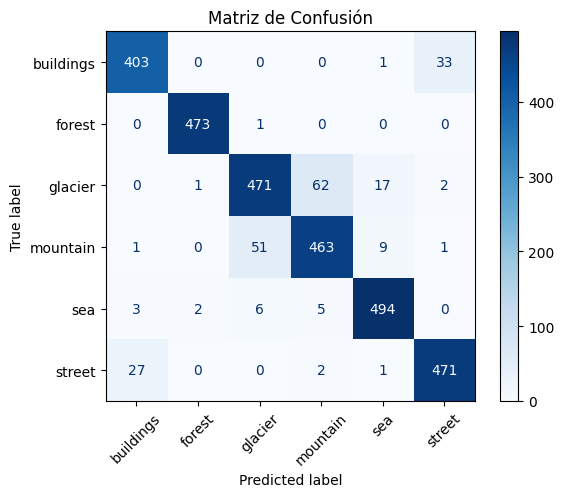


Matriz de Confusión con Nombres de Clases:
           buildings  forest  glacier  mountain  sea  street
buildings        403       0        0         0    1      33
forest             0     473        1         0    0       0
glacier            0       1      471        62   17       2
mountain           1       0       51       463    9       1
sea                3       2        6         5  494       0
street            27       0        0         2    1     471


In [65]:
# Matriz de confusión
plot_confusion_matrix(model_tensorflow, test_ds)

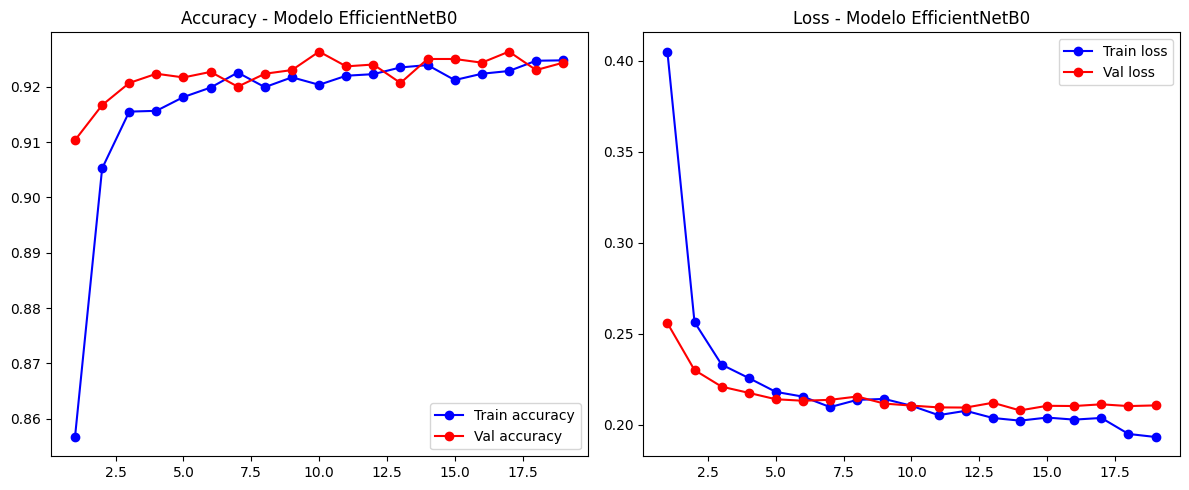

In [66]:
plot_training(historia_tf, "Modelo EfficientNetB0")

Probamos el modelo en una imagen de cada clase y lo mostramos:

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


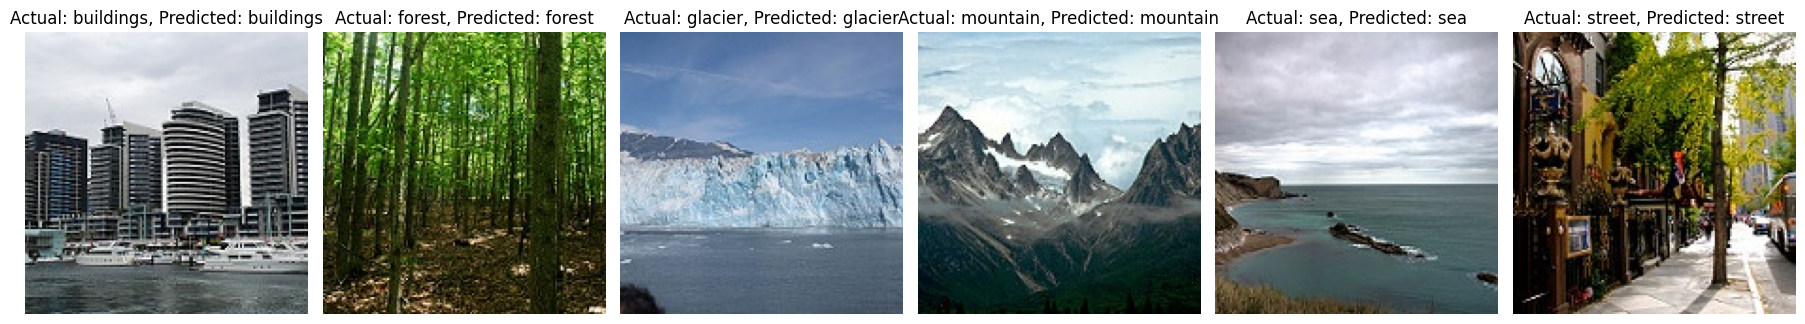

In [67]:
# Seleccionamos una imagen aleatoria de cada clase
sample_images = []
for class_name in class_names:
    class_folder = data_train / class_name
    image_paths = list(class_folder.glob("*.jpg"))
    selected_image = random.choice(image_paths)
    sample_images.append((selected_image, class_name))

# Mostrar 6 imágenes con sus clases reales y predichas
fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for i, ax in enumerate(axes):

    # Preprocesar imagen
    image_path, actual_class = sample_images[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    # Agregar dimensión batch
    image = np.expand_dims(image, axis=0)

    # Predecir
    prediction = model_tensorflow.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    # Display result
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()

#### Conclusión

In [68]:
# agregamos nuevos datos al dataframe existente
metricas_tensorflow = {
    'Modelo': 'Modelo Tensorflow',
    'Precisión en test': accuracy,
    'Pérdida en test': loss
}
comparacion.loc[len(comparacion)] = metricas_tensorflow
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.562667         1.175239
1  Modelo Convolucional y Denso           0.835667         0.452867
2     Modelo Bloques Residuales           0.881000         0.349607
3             Modelo Tensorflow           0.925000         0.207756

El modelo EfficientNetB0 tiene un mejor rendimiento, con un 92% de acierto en las predicciones y una pérdida de 0.2. Este desempeño nos muestra la efectividad del transfer learning, aprovechando características previamente aprendidas en grandes datasets y adaptándolas al problema actual con un costo computacional más bajo. Este modelo no solo mejora la precisión, sino que también reduce el error más que en cualquier modelo anterior.

Según los resultados de la matriz de confusión y teniendo en cuenta las métricas obtenidas, distinguir entre 'mountain' y 'glacier' sigue siendo un desafío para los modelos vistos.

Según las curvas de entrenamiento:
- Accuracy: la precisión de entrenamiento y validación convergen rápidamente, manteniéndose estables y cercanas.
- Loss: la pérdida disminuye drásticamente en las primeras épocas y se estabiliza en un nivel muy bajo.
El modelo se ajusta bien a los datos, sin sobreajuste.

Exploramos otras técnicas de TensorFlow:

MobileNet
- Accuracy: 67%
- Loss: 0.7

ResNet50:
- Accuracy: 92%
- Loss: 0.9

EfficientNetB0 fue el que más se destacó entre ellos.
En resumen, el modelo tuvo un buen desempeño.

## **Conclusión Final y Comparación de modelos**



In [69]:
comparacion

Modelo  Precisión en test  Pérdida en test
0                  Modelo Denso           0.562667         1.175239
1  Modelo Convolucional y Denso           0.835667         0.452867
2     Modelo Bloques Residuales           0.881000         0.349607
3             Modelo Tensorflow           0.925000         0.207756

A lo largo del trabajo, vimos distintas arquitecturas de Redes Neuronales para clasificar imágenes de escenas naturales.

Comenzamos con un modelo denso simple y progresivamente incorporamos técnicas más sofisticadas como convoluciones, bloques residuales y TransferLearning.

En términos generales:

*   El modelo denso fue el menos efectivo, limitado por su incapacidad para aprovechar la estructura espacial de las imágenes.

*   El modelo convolucional denso demostró una mejora gracias al uso de filtros espaciales y data augmentation.

*   El modelo con bloques residuales mostró cómo arquitecturas más profundas pueden ser estables y eficientes si se diseñan adecuadamente.

*   El modelo con transferencia de aprendizaje (EfficientNetB0) fue el más eficiente y preciso, destacándose como la opción más robusta y práctica.

En conclusión: pudimos probar distintos tipos de redes neuronales y ver cómo cada mejora impacta en la clasificación de imágenes. Comprobamos que:
- Los modelos simples no son tan efectivos.
- Las redes convolucionales y los bloques residuales mejoran significativamente ya que aprovechan la estructura espacial.
- Los modelos preentrenados como EfficientNetB0, dan mejores resultados, logrando un balance entre precisión, eficiencia y costo computacional.